In [83]:
import os
import sys
import glob
import numpy as np
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv

%matplotlib inline


In [84]:

# Paths to important configuration tables
PDB_TO_UNIPROT_TABLE_PATH = "/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/simulation-analysis/gpcrdb-freq-config/GPCR_PDB_List.txt"
GPCRDB_TABLE_PATH="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/simulation-analysis/gpcrdb-freq-config/All_species_gpcrdb_numbers_strOnly.txt"
GPCRDB_RESIDUE_FREQ_TABLE="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/simulation-analysis/gpcrdb-freq-config/gpcrdb_residue_conservation.txt"

# Single letter to three letter representation of amino acids
aa1to3_dict = {'A':'Ala','R':'Arg','N':'Asn','D':'Asp','C':'Cys','E':'Glu','Q':'Gln','G':'Gly','H':'His','I':'Ile','L':'Leu','K':'Lys','M':'Met','F':'Phe','P':'Pro','S':'Ser','T':'Thr','W':'Trp','Y':'Tyr','V':'Val'}
aa3to1_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'ASN': 'N', 'GLN': 'Q', 'LYS': 'K', 'THR': 'T', 'PRO': 'P', 'HIS': 'H', 'PHE': 'F', 'ALA': 'A', 'GLY': 'G', 'ILE': 'I', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

# Alphabetical list of 20 amino acids
ALPHABETICAL_AA_LIST = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLU', 'GLN', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

POLAR_AA_SET = set(["ARG", "LYS", "ASP", "GLU", "GLN", "ASN", "HIS", "SER", "THR", "TYR", "CYS", "TRP"])

POSITION_CONSERVATION_PATH="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/simulation-analysis/gpcrdb-freq-config/gpcrdb_residue_conservation.txt"

def not_bulk_water_region(gpcrdb):
    """
        Determine if given position is near bulk water. 
    """
    tm, num = map(int, gpcrdb.strip().split("x"))
    if(tm == 1 and (num >= 33 and num <= 57)): return True
    elif(tm == 2 and (num >= 40 and num <= 63)): return True
    elif(tm == 3 and (num >= 25 and num <= 54)): return True
    elif(tm == 4 and (num >= 41 and num <= 62)): return True 
    elif(tm == 5 and (num >= 39 and num <= 63)): return True
    elif(tm == 6 and (num >= 35 and num <= 58)): return True 
    elif(tm == 7 and (num >= 34 and num <= 55)): return True
    else: return False


def position_to_conserve_freq():
	f = open(POSITION_CONSERVATION_PATH, 'r')
	header = f.readline()
	pos_to_conserve_freq = {}
	for line in f:
		linfo = line.strip().split("\t")
		position = linfo[0]
		max_conserve_freq = max(map(float, linfo[1:]))
		pos_to_conserve_freq[position] = max_conserve_freq

	return pos_to_conserve_freq

def position_to_polarity_freq():
	f = open(POSITION_CONSERVATION_PATH, 'r')
	header = f.readline().strip().split("\t")
	polar_aa_indices = [header.index(aa) for aa in POLAR_AA_SET]
	pos_to_polarity_freq = {}
	for line in f:
		linfo = line.strip().split("\t")
		position = linfo[0]
		polarity_sum = 0
		for pi in polar_aa_indices:
			polarity_sum += float(linfo[pi])
		pos_to_polarity_freq[position] = polarity_sum
	return pos_to_polarity_freq


# Rename amino acids to common name
def fixAminoAcidNames(key):
	key = key.replace("HSD", "HIS")
	key = key.replace("HSE", "HIS")
	key = key.replace("HSP", "HIS")
	key = key.replace("HIE", "HIS")
	key = key.replace("HIP", "HIS")
	key = key.replace("HID", "HIS")
	key = key.replace("GLH", "GLU")
	key = key.replace("ASH", "ASP")
	key = key.replace("CYP", "CYS")
	key = key.replace("CYX", "CYS")
	return key

# Retrive gpcrdb from dictionary for specified residue. Return "-" if not found
def getGPCRDB(res, GPCRDB_DICT):
	res = fixAminoAcidNames(res)
	if(res not in GPCRDB_DICT):
		print(res + " not found.")
		return "None"
	return GPCRDB_DICT[res]

# Create directory if not exist
def createDirectory(OUTPUT_FILE):
	directory = os.path.dirname(OUTPUT_FILE)
	if not os.path.exists(directory):
		os.makedirs(directory)

# Generate write file descriptor 
def genWriteDescriptor(OUTPUT_FILE):
	createDirectory(OUTPUT_FILE)
	return open(OUTPUT_FILE, 'w')


# Retrieve Uniprot Code for the PDB_CODE from pdb_to_uniprot_table_path
def getUniprotCode(PDB_CODE):
	f = open(PDB_TO_UNIPROT_TABLE_PATH, 'r')
	for line in f:
		if(line == "\n"): continue 
		l_info = line.split("\t")
		uniprot_code, pdb = l_info[0].strip(), l_info[2].strip()
		if(PDB_CODE.upper() == pdb.upper()): return uniprot_code.upper()
	print("PDB_CODE Not Found in PDB To Uniprot Table")
	exit(1)


# Given uniprot code reads through GPCRDB_TABLE_PATH to generate the amino acid
# to gpcrdb number table. 
# Output {"ASP112": "1x50", "ARG116":"2x45"}
def genGpcrdbDict(UNIPROT_CODE):
	GPCRDB_DICT = {}
	f = open(GPCRDB_TABLE_PATH, 'r')
	for line in f: 
		l_info = line.split("\t")
		uniprot, resnum, resname, gpcrdb = l_info[0].strip(), l_info[1].strip(), l_info[2].strip(), l_info[4].strip()
		if(uniprot.upper() == UNIPROT_CODE.upper()):
			key = resname.upper() + resnum 
			GPCRDB_DICT[key] = gpcrdb
	return GPCRDB_DICT


# Generates the residue to gpcrdb table for given pdb
def genResidueToGpcrdbTable(PDB_CODE):
	UNIPROT_CODE = getUniprotCode(PDB_CODE)
	GPCRDB_DICT = genGpcrdbDict(UNIPROT_CODE)
	return GPCRDB_DICT


In [85]:
USAGE_STR = """
# Purpose
# Takes in a folder of residue_water_conservation frequencies for multiple replicates and
# experimental condition. Plot residue position conservation vs water-mediated interaction 
# frequency. 

# Usage 
# python plot_water_residue_conservation.py <INPUT_DIR> <-errbar>

# Arguments 
# <INPUT_DIR> Absolute path to the directory containing individual files per replicate/experimental 
# condition associating gpcrdb to water-mediated interaction frequency.
# <-errbar> Optional argument if want to plot error bar range

# Example
INPUT_DIR="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/121316/active_restrained_receptors"
cd /scratch/PI/rondror/akma327/DynamicNetworks/src/analysis/residue-water-conservation
python plot_water_residue_conservation.py $INPUT_DIR

INPUT_DIR="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/121316/inactive_receptors"
cd /scratch/PI/rondror/akma327/DynamicNetworks/src/analysis/residue-water-conservation
python plot_water_residue_conservation.py $INPUT_DIR


"""

K_MIN_ARG = 2

POLARITY_FREQ_CUTOFF = 0.5 # Only display positions that are polar

In [104]:
def getPosToFreqs(INPUT_DIR):
	"""
		Generate dictionary with key = "5x53", value = [0.90, 0.91, 0.95] where each entry 
		is from different replicate/experimental condition 
	"""
	pos_to_rw_freq = {}
	paths = glob.glob(INPUT_DIR + "/*")
	for path in paths: 
		f = open(path, 'r')
		for line in f:
			if("x" not in line): continue
			linfo = line.strip().split("\t")
			pos, freq = linfo[0], float(linfo[1])
			if(pos not in pos_to_rw_freq):
				pos_to_rw_freq[pos] = []
			pos_to_rw_freq[pos].append(freq)
	return pos_to_rw_freq



def plot_water_residue_conservation(INPUT_DIR, ERROR_BAR):
	pos_to_aa_freq = position_to_conserve_freq()
	pos_to_polarity = position_to_polarity_freq()
	pos_to_rw_freq = getPosToFreqs(INPUT_DIR)
	pos_list, aa_conserve, aa_polarity, rw_avg_conserve, lower_range, upper_range = [], [], [], [], [], []
	for pos in pos_to_rw_freq:
		pos_polarity = pos_to_polarity[pos]
		if(pos_polarity > POLARITY_FREQ_CUTOFF and not_bulk_water_region(pos)):
			pos_list.append(pos)
			aa_conserve.append(pos_to_aa_freq[pos])
			aa_polarity.append(pos_polarity)
			rw_freqs = pos_to_rw_freq[pos]
			avg_freq = np.mean(rw_freqs)
			rw_avg_conserve.append(avg_freq)
			lower_range.append(avg_freq - min(rw_freqs))
			upper_range.append(max(rw_freqs) - avg_freq)

	tot_range = [lower_range, upper_range]
	if(ERROR_BAR == False):
		# plt.plot(aa_conserve, rw_avg_conserve, 'bo')
		fig, ax = plt.subplots()
		ax.scatter(aa_conserve, rw_avg_conserve, c=aa_polarity, s=100)

	else:
		plt.errorbar(aa_conserve, rw_avg_conserve, tot_range, linestyle='None', marker='^')
	plt.xlabel("Positional Sequence Conservation", fontsize = 16)
	plt.ylabel("Residue water interaction frequency", fontsize = 16)
	plt.title("Active Unrestrained Receptors - Sequence Conservation vs Residue Water Conservation", fontsize = 20)
	plt.show()

	return pos_list, rw_avg_conserve, aa_conserve, aa_polarity

def plot_rw_avg_hist(rw_avg_conserve):
	plt.hist(rw_avg_conserve)
	plt.show()


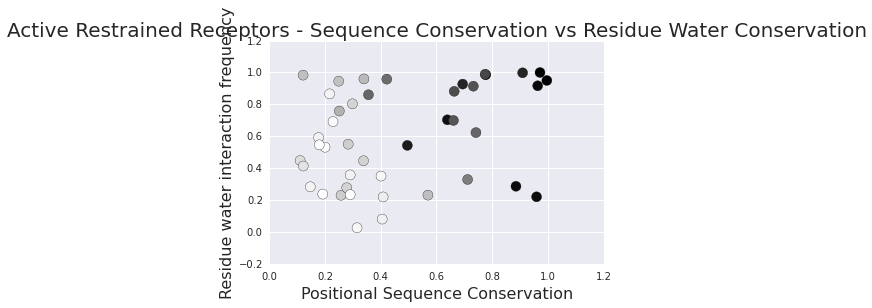

In [97]:
INPUT_DIR="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/121316/active_restrained_receptors"
ERROR_BAR = False

pos_list, rw_avg_conserve, aa_conserve, aa_polarity = plot_water_residue_conservation(INPUT_DIR, ERROR_BAR)

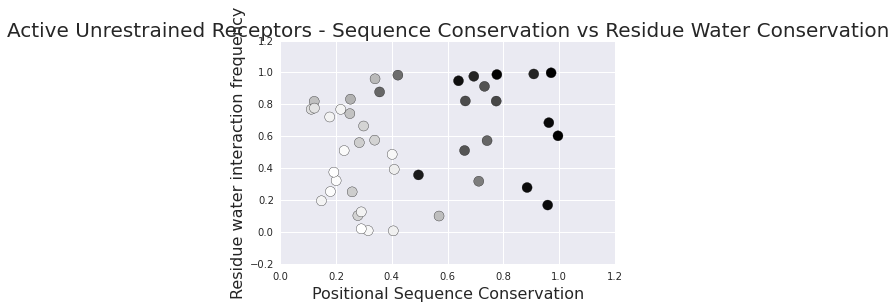

In [105]:
INPUT_DIR="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/121316/active_unrestrained_receptors"
ERROR_BAR = False

pos_list, rw_avg_conserve, aa_conserve, aa_polarity = plot_water_residue_conservation(INPUT_DIR, ERROR_BAR)

In [88]:
d = {"hydration": pd.Series(rw_avg_conserve, index = pos_list), "aa_conserve": pd.Series(aa_conserve, index = pos_list), "aa_polarity": pd.Series(aa_polarity, index = pos_list)}
df = pd.DataFrame(d)



In [103]:
# Active Restrained Top Right
# High Conservation, Low Hydration

high_conserve = df[df.aa_conserve > 0.5]
high_conserve[high_conserve.hydration > 0.5]

,aa_conserve,aa_polarity,hydration
3x39,0.74180,0.83607,0.623066
3x49,0.63934,0.97130,0.703160
1x50,0.99590,1.00000,0.949860
2x50,0.96311,0.98361,0.916648
6x47,0.73251,0.87243,0.913979
7x53,0.90909,0.93801,0.997976
7x49,0.77686,0.99586,0.985791
7x45,0.69421,0.93801,0.927103
7x46,0.66116,0.86776,0.699295
3x50,0.97131,1.00001,0.999957


In [95]:
# Moderately aa_conserve, High Hydration
mod_conserve = df[df.aa_conserve > 0.6]
mod_conserve = mod_conserve[mod_conserve.aa_conserve < 0.8]
mod_conserve[mod_conserve.hydration > 0.8]

,aa_conserve,aa_polarity,hydration
6x47,0.73251,0.87243,0.913979
7x49,0.77686,0.99586,0.985791
7x45,0.69421,0.93801,0.927103
3x51,0.66393,0.88115,0.881749
5x58,0.77459,0.88935,0.988808


In [89]:
# Active Restrained Bottom Right
# High Conservation, Low Hydration

high_conserve = df[df.aa_conserve > 0.5]
high_conserve[high_conserve.hydration < 0.5]

,aa_conserve,aa_polarity,hydration
3x47,0.56967,0.68443,0.230745
4x50,0.95902,0.97952,0.220269
3x25,0.88525,0.97952,0.286196
6x48,0.71193,0.79425,0.328859


In [90]:
# Active Restrained  Top Left
# Low Conservation, High Hydration
low_conserve = df[df.aa_conserve < 0.5]
low_conserve[low_conserve.hydration > 0.5]

,aa_conserve,aa_polarity,hydration
3x32,0.22951,0.52051,0.691839
3x42,0.20082,0.51230,0.531304
3x26,0.35656,0.83607,0.860364
2x45,0.49590,0.95493,0.542604
2x40,0.42213,0.82376,0.958234
6x52,0.28395,0.65020,0.550314
6x58,0.12227,0.68122,0.983489
5x60,0.21721,0.54507,0.865758
5x63,0.29918,0.63526,0.803475
6x35,0.34025,0.69296,0.959631


In [91]:
# Active Restrained Bottom Left
# Low Conservation, Low Hydration
low_conserve = df[df.aa_conserve < 0.5]
low_conserve[low_conserve.hydration < 0.5]

,aa_conserve,aa_polarity,hydration
3x35,0.25820,0.65165,0.229693
3x37,0.27869,0.63935,0.277186
7x35,0.11157,0.61157,0.447772
3x44,0.31557,0.53278,0.025925
4x57,0.29091,0.50001,0.233749
2x56,0.19262,0.50411,0.237270
6x55,0.14815,0.54734,0.282949
7x47,0.40909,0.57025,0.219365
7x42,0.33884,0.64048,0.446247
5x57,0.40574,0.56148,0.080590


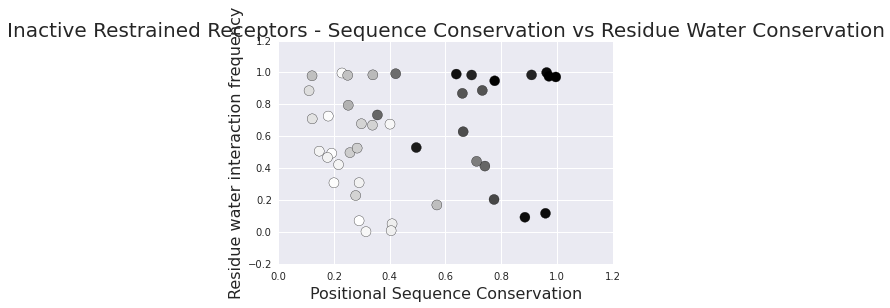

In [100]:
INPUT_DIR="/scratch/PI/rondror/akma327/DynamicNetworks/data/crystal-analysis/residue-water-conservation/121316/inactive_receptors"
ERROR_BAR = False

pos_list, rw_avg_conserve, aa_conserve, aa_polarity = plot_water_residue_conservation(INPUT_DIR, ERROR_BAR)

In [101]:
# Inactive Top Right
high_conserve = df[df.aa_conserve > 0.5]
high_conserve[high_conserve.hydration > 0.5]

,aa_conserve,aa_polarity,hydration
3x39,0.74180,0.83607,0.623066
3x49,0.63934,0.97130,0.703160
1x50,0.99590,1.00000,0.949860
2x50,0.96311,0.98361,0.916648
6x47,0.73251,0.87243,0.913979
7x53,0.90909,0.93801,0.997976
7x49,0.77686,0.99586,0.985791
7x45,0.69421,0.93801,0.927103
7x46,0.66116,0.86776,0.699295
3x50,0.97131,1.00001,0.999957


In [102]:
# Inactive Bottom Right

high_conserve = df[df.aa_conserve > 0.5]
high_conserve[high_conserve.hydration < 0.5]

,aa_conserve,aa_polarity,hydration
3x47,0.56967,0.68443,0.230745
4x50,0.95902,0.97952,0.220269
3x25,0.88525,0.97952,0.286196
6x48,0.71193,0.79425,0.328859
